In [1]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-fa-cartpole/'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, arrange_data
from nn_models import MLP, PSD, MatrixNet
from symoden import SymODEN_R1_T1
from utils import L2_loss, from_pickle
import imageio


In [2]:
DPI = 600
FORMAT = 'pdf'
LINE_WIDTH = 2

def get_args():
    return {'num_angle': 1,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'name': 'fa_cart',
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'num_points': 4,
         'gpu': 0,
         'solver': 'rk4'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView(get_args())


 ## Load models

In [3]:
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
def get_model(args, baseline, structure, naive, num_points):
    M_net = PSD(3, 400, 2).to(device)
    g_net = MatrixNet(3, 300, 4, shape=(2,2)).to(device)
    if structure == False:
        if naive and baseline:
            raise RuntimeError('argument *baseline* and *naive* cannot both be true')
        elif naive:
            input_dim = 6
            output_dim = 5
            nn_model = MLP(input_dim, 1000, output_dim, args.nonlinearity).to(device)
            model = SymODEN_R1_T1(args.num_angle, H_net=nn_model, device=device, baseline=baseline, naive=naive, u_dim=2)
        elif baseline:
            input_dim = 6
            output_dim = 4
            nn_model = MLP(input_dim, 700, output_dim, args.nonlinearity).to(device)
            model = SymODEN_R1_T1(args.num_angle, H_net=nn_model, M_net=M_net, device=device, baseline=baseline, naive=naive, u_dim=2)
        else:
            input_dim = 5
            output_dim = 1
            nn_model = MLP(input_dim, 500, output_dim, args.nonlinearity).to(device)
            model = SymODEN_R1_T1(args.num_angle, H_net=nn_model, M_net=M_net, g_net=g_net, device=device, baseline=baseline, naive=naive, u_dim=2)
    elif structure == True and baseline ==False and naive==False:
        V_net = MLP(3, 300, 1).to(device)
        model = SymODEN_R1_T1(args.num_angle, M_net=M_net, V_net=V_net, g_net=g_net, device=device, baseline=baseline, structure=True, u_dim=2).to(device)
    else:
        raise RuntimeError('argument *structure* is set to true, no *baseline* or *naive*!')

    if naive:
        label = '-naive_ode'
    elif baseline:
        label = '-baseline_ode'
    else:
        label = '-hnn_ode'
    struct = '-struct' if structure else ''
    path = '{}/{}{}{}-{}-p{}.tar'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    model.load_state_dict(torch.load(path, map_location=device))
    path = '{}/{}{}{}-{}-p{}-stats.pkl'.format(args.save_dir, args.name, label, struct, args.solver, args.num_points)
    stats = from_pickle(path)
    return model, stats

symoden_ode_struct_model, symoden_ode_struct_stats = get_model(args, baseline=False, structure=True, naive=False, num_points=args.num_points)



In [4]:
# time info for simualtion
time_step = 400 ; n_eval = 400
t_span = [0,time_step*0.02]
t_linspace_true = np.linspace(t_span[0], time_step, time_step)*0.02
t_linspace_model = np.linspace(t_span[0], t_span[1], n_eval)
# angle info for simuation
q0 = 2
x0 = 1.0
u10 = 0.0 ; u20 = 0.0

# record video
import gym
from gym import wrappers
env = gym.make('My_FA_CartPole-v0')
env = gym.wrappers.Monitor(env, './videos/' + 'cartpole-fa-embed' + '/', force=True) # , video_callable=lambda x: True, force=True


env.reset()
env.env.state = np.array([x0, 0.0, q0, 0.0], dtype=np.float32)
obs = env.env._get_obs()
y = torch.tensor([obs[0], obs[1], obs[2], obs[3], obs[4], u10, u20], requires_grad=True, device=device, dtype=torch.float32).view(1, 7)

t_eval = torch.linspace(t_span[0], t_span[1], n_eval).to(device)

y_traj = []
y_traj.append(y)
frames = []
for i in range(len(t_eval)-1):
    frames.append(env.render(mode='rgb_array'))

    x_cos_q_sin_q, x_dot_q_dot, u = torch.split(y, [3, 2, 2], dim=1)
    M_q_inv = symoden_ode_struct_model.M_net(x_cos_q_sin_q)
    x_dot_q_dot_aug = torch.unsqueeze(x_dot_q_dot, dim=2)
    p = torch.squeeze(torch.matmul(torch.inverse(M_q_inv), x_dot_q_dot_aug), dim=2)
    x_cos_q_sin_q_p = torch.cat((x_cos_q_sin_q, p), dim=1)
    x_cos_q_sin_q, p = torch.split(x_cos_q_sin_q_p, [3, 2], dim=1)
    M_q_inv = symoden_ode_struct_model.M_net(x_cos_q_sin_q)
    _, cos_q, sin_q = torch.chunk(x_cos_q_sin_q, 3,dim=1)
    V_q = symoden_ode_struct_model.V_net(x_cos_q_sin_q)   
    p_aug = torch.unsqueeze(p, dim=2)
    H = torch.squeeze(torch.matmul(torch.transpose(p_aug, 1, 2), torch.matmul(M_q_inv, p_aug)))/2.0 + torch.squeeze(V_q)
    dH = torch.autograd.grad(H.sum(), x_cos_q_sin_q_p, create_graph=True)[0]
    dHdx, dHdcos_q, dHdsin_q, dHdp= torch.split(dH, [1, 1, 1, 2], dim=1)
    dV = torch.autograd.grad(V_q, x_cos_q_sin_q)[0]
    dVdx, dVdcos_q, dVdsin_q= torch.chunk(dV, 3, dim=1)
    dV_q = - dVdcos_q * sin_q + dVdsin_q * cos_q
    g_xq = symoden_ode_struct_model.g_net(x_cos_q_sin_q)
    g_xq_T = torch.transpose(g_xq, 1, 2)
    inv_g_g_T = torch.inverse(torch.matmul(g_xq, g_xq_T))
    g_T_inv_g_g_T = torch.matmul(g_xq_T, inv_g_g_T)

    # bracket in beta_q

    energy_shaping = torch.zeros(2, 1, dtype=torch.float32, device=device)
    energy_shaping[0][0] = 2 * dVdx[0][0] - x_cos_q_sin_q[0][0]
    energy_shaping[1][0] = 2 * dV_q[0][0]


    damping_injection = -2 * p.T

    u = torch.matmul(g_T_inv_g_g_T, energy_shaping+damping_injection)

    u = u.squeeze().detach().cpu().numpy()
    obs, _, _, _ = env.step(u)
    y = torch.tensor([obs[0], obs[1], obs[2], obs[3], obs[4], u[0], u[1]], requires_grad=True, device=device, dtype=torch.float32).view(1, 7)

    y_traj.append(y)
env.close()
# imageio.mimsave('./videos/cartpole-fa-embed/cartpole-fa-embed.gif', frames, duration=0.02)

y_traj = torch.stack(y_traj).view(-1, 7).detach().cpu().numpy()



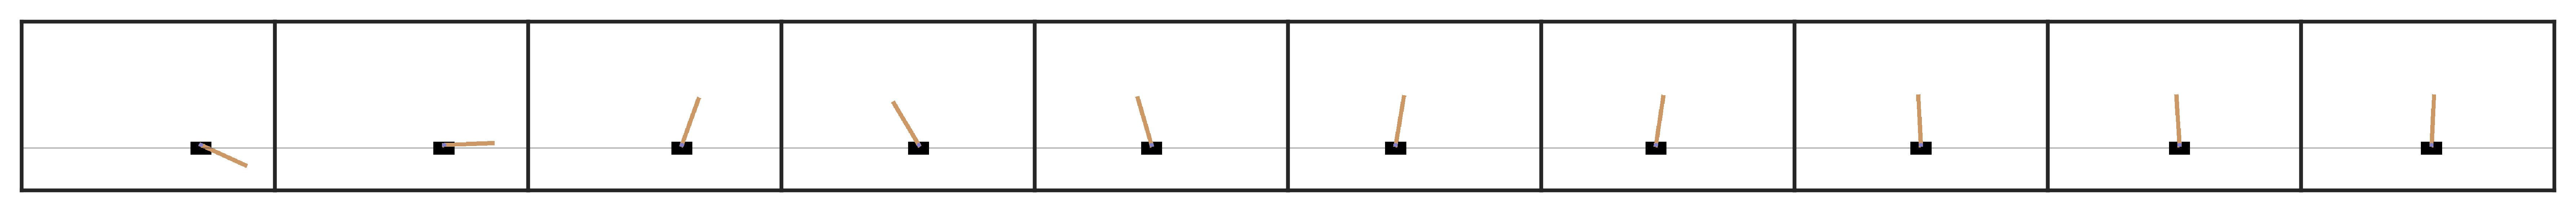

In [5]:
with plt.style.context("seaborn-white"):
    fig = plt.figure(figsize=(12, 1.3), dpi=DPI)
    plt.rcParams["axes.grid"] = False
    ax = plt.subplot(1, 10, 1)
    ax.imshow(frames[0])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 2)
    ax.imshow(frames[15])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 3)
    ax.imshow(frames[30])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 4)
    ax.imshow(frames[45])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 5)
    ax.imshow(frames[60])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 6)
    ax.imshow(frames[75])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 7)
    ax.imshow(frames[90])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 8)
    ax.imshow(frames[105])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 9)
    ax.imshow(frames[120])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax = plt.subplot(1, 10, 10)
    ax.imshow(frames[135])
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    plt.tight_layout()

    fig.subplots_adjust(hspace=0, wspace=0)

    # fig.savefig('{}/fig-fa-cartpole-frame.{}'.format(args.fig_dir, FORMAT))




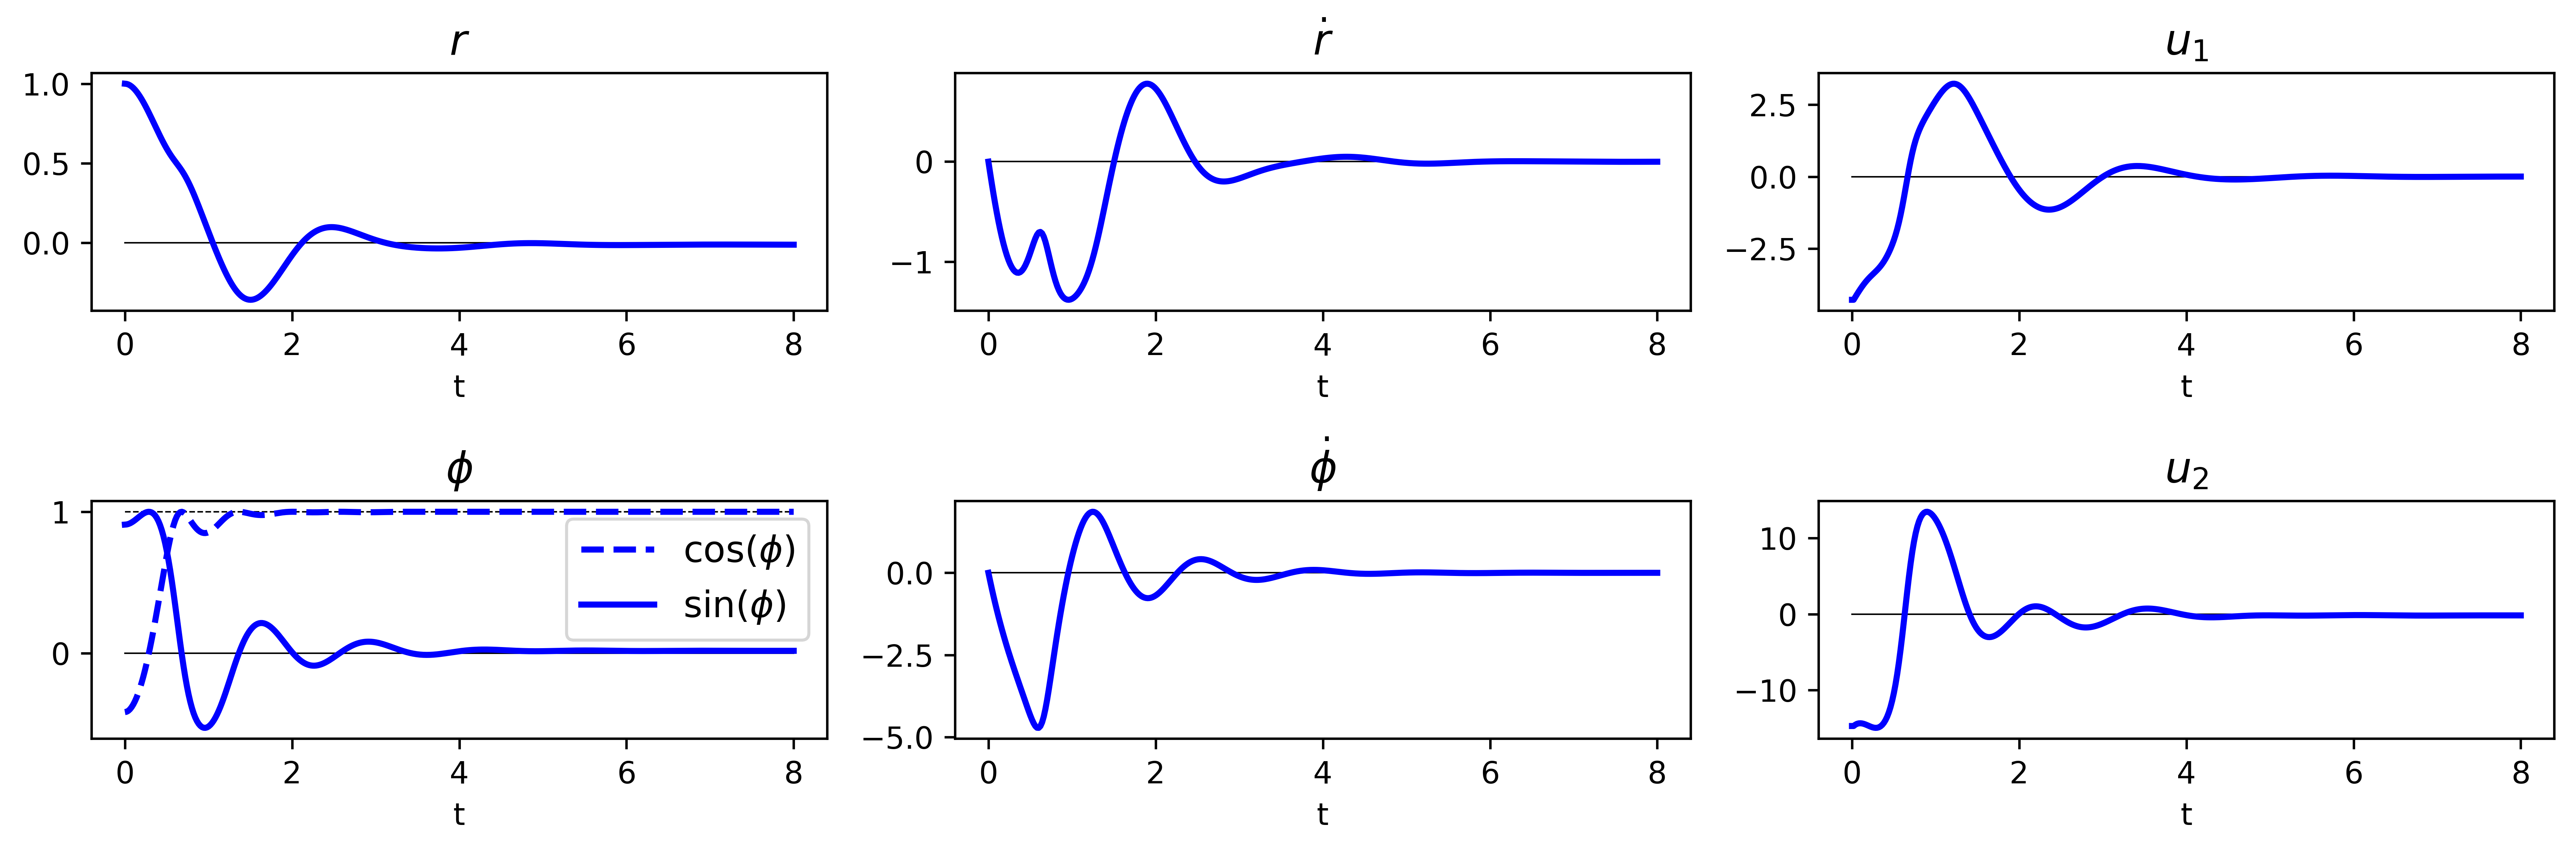

In [6]:
y_traj[0, 5] = y_traj[1, 5]
y_traj[0, 6] = y_traj[1, 6]


fig = plt.figure(figsize=[12, 4], dpi=DPI)
plt.subplot(2, 3, 1)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), color='k', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 0], color='b', linewidth=LINE_WIDTH)
plt.title("$r$", fontsize=14)
plt.xlabel('t')

plt.subplot(2, 3, 4)
plt.plot(t_eval.numpy(), 1 * np.ones_like(t_eval.numpy()), 'k--', linewidth=0.5)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 1], 'b--', label=r"$\cos(\phi)$", linewidth=LINE_WIDTH)
plt.plot(t_eval.numpy(), y_traj[:, 2], 'b-', label=r"$\sin(\phi)$", linewidth=LINE_WIDTH)
plt.title("$\phi$", fontsize=14)
plt.xlabel('t')
plt.legend(fontsize=12)

plt.subplot(2, 3, 2)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 3], color='b', linewidth=LINE_WIDTH)
plt.title("$\dot{r}$", fontsize=14)
plt.xlabel('t')

plt.subplot(2, 3, 5)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 4], color='b', linewidth=LINE_WIDTH)
plt.title("$\dot{\phi}$", fontsize=14)
plt.xlabel('t')

plt.subplot(2, 3, 3)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 5], color='b', linewidth=LINE_WIDTH)
plt.title("$u_1$", fontsize=14)
plt.xlabel('t')

plt.subplot(2, 3, 6)
plt.plot(t_eval.numpy(), 0 * np.ones_like(t_eval.numpy()), 'k-', linewidth=0.5)
plt.plot(t_eval.numpy(), y_traj[:, 6], color='b', linewidth=LINE_WIDTH)
plt.title("$u_2$", fontsize=14)
plt.xlabel('t')

plt.tight_layout()
# fig.savefig('{}/fig-fa-cartpole-ctrl.{}'.format(args.fig_dir, FORMAT))